<!-- ---
title: "Week 6"
title-block-banner: true
title-block-style: default
execute:
  freeze: true
  cache: true
format: html
# format: pdf
--- -->

In [1]:
dir <- "~/work/courses/stat380/weeks/week-12/"
# renv::activate(dir)


#### Packages we will require this week

In [156]:
packages <- c(
    # Old packages
    "ISLR2",
    "dplyr",
    "tidyr",
    "readr",
    "purrr",
    "repr",
    "tidyverse",
    "kableExtra",
    "IRdisplay",
    "car",
    "corrplot",
    # NEW
    "torch",
    "torchvision",
    "luz"
)

# renv::install(packages)
sapply(packages, require, character.only=TRUE)

ISLR2       dplyr       tidyr       readr       purrr        repr 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
  tidyverse  kableExtra   IRdisplay         car    corrplot       torch 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
torchvision         luz 
       TRUE        TRUE

---

# Tue, Apr 12

### Agenda:

1. Real-world neural network classification
1. Dataloaders
1. Torch for image classification

<br><br><br>

## Titanic

In [3]:
url <- "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"

df <- read_csv(url) %>%
    mutate_if(\(x) is.character(x), as.factor) %>%
    mutate(y = Survived) %>%
    select(-c(Name, Survived)) %>%
    (\(x) {
        names(x) <- tolower(names(x))
        x
    })

df %>% head

Rows: 887 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Name, Sex
dbl (6): Survived, Pclass, Age, Siblings/Spouses Aboard, Parents/Children Ab...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pclass,sex,age,siblings/spouses aboard,parents/children aboard,fare,y
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,male,22,1,0,7.2500,0
1,female,38,1,0,71.2833,1
3,female,26,0,0,7.9250,1
1,female,35,1,0,53.1000,1
3,male,35,0,0,8.0500,0
3,male,27,0,0,8.4583,0


## Breast Cancer Prediction

In [4]:
# url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

# col_names <- c("id", "diagnosis", paste0("feat", 1:30))

# df <- read_csv(
#         url, col_names, col_types = cols()
#     ) %>% 
#     select(-id) %>% 
#     mutate(y = ifelse(diagnosis == "M", 1, 0)) %>%
#     select(-diagnosis)


# df %>% head

### Train/Test Split

In [5]:
k <- 5

test_ind <- sample(
    1:nrow(df), 
    floor(nrow(df) / k),
    replace=FALSE
)

In [6]:
df_train <- df[-test_ind, ]
df_test  <- df[test_ind, ]

nrow(df_train) + nrow(df_test) == nrow(df)

[1] TRUE

### Benchmark with Logistic Regression

In [7]:
fit_glm <- glm(
    y ~ ., 
    df_train %>% mutate_at("y", factor), 
    family = binomial()
)

glm_test <- predict(
    fit_glm, 
    df_test,
    output = "response"
)

glm_preds <- ifelse(glm_test > 0.5, 1, 0)
table(glm_preds, df_test$y)

         
glm_preds   0   1
        0 100  23
        1  13  41

### Neural Net Model

In [8]:
NNet <- nn_module(
  initialize = function(p, q1, q2, q3) {  
    self$hidden1 <- nn_linear(p, q1)
    self$hidden2 <- nn_linear(q1, q2)
    self$hidden3 <- nn_linear(q2, q3)
    self$output <- nn_linear(q3, 1)
    self$activation <- nn_relu()
    self$sigmoid <- nn_sigmoid()
  },
    
  forward = function(x) {
    x %>% 
      self$hidden1() %>% self$activation() %>% 
      self$hidden2() %>% self$activation() %>% 
      self$hidden3() %>% self$activation() %>% 
      self$output() %>% self$sigmoid()
  }
)

### Fit using Luz

In [9]:
M <- model.matrix(y ~ 0 + ., data = df_train)

In [10]:
fit_nn <- NNet %>%
    #
    # Setup the model
    #
    setup(
        loss = nn_bce_loss(),
        optimizer = optim_adagrad, 
        metrics = list(
            luz_metric_accuracy()
        )
    ) %>% 
    #
    # Set the hyperparameters
    #
    set_hparams(p=ncol(M), q1=256, q2=128, q3=64) %>% 
    set_opt_hparams(lr=1e-2) %>% 
    #
    # Fit the model
    #
    fit(
        data = list(
            model.matrix(y ~ 0 + ., data = df_train),
            df_train %>% select(y) %>% as.matrix
        ),
        valid_data = list(
            model.matrix(y ~ 0 + ., data = df_test),
            df_test %>% select(y) %>% as.matrix
        ),
        epochs = 50, 
        verbose = TRUE
    )

Epoch 1/50
Train metrics: Loss: 0.9823 - Acc: 12.3465
Valid metrics: Loss: 0.6505 - Acc: 10.9774
Epoch 2/50
Train metrics: Loss: 0.6353 - Acc: 12.3099
Valid metrics: Loss: 0.7829 - Acc: 10.9774
Epoch 3/50
Train metrics: Loss: 0.6327 - Acc: 12.4563
Valid metrics: Loss: 0.6084 - Acc: 10.9774
Epoch 4/50
Train metrics: Loss: 0.5976 - Acc: 12.4563
Valid metrics: Loss: 0.5915 - Acc: 10.9774
Epoch 5/50
Train metrics: Loss: 0.601 - Acc: 12.4563
Valid metrics: Loss: 0.5774 - Acc: 10.9774
Epoch 6/50
Train metrics: Loss: 0.5752 - Acc: 12.4197
Valid metrics: Loss: 0.5847 - Acc: 10.9774
Epoch 7/50
Train metrics: Loss: 0.5796 - Acc: 12.4563
Valid metrics: Loss: 0.5675 - Acc: 10.9774
Epoch 8/50
Train metrics: Loss: 0.5633 - Acc: 12.4197
Valid metrics: Loss: 0.558 - Acc: 10.9774
Epoch 9/50
Train metrics: Loss: 0.5642 - Acc: 12.3831
Valid metrics: Loss: 0.5426 - Acc: 10.9774
Epoch 10/50
Train metrics: Loss: 0.5619 - Acc: 12.4563
Valid metrics: Loss: 0.533 - Acc: 10.9774
Epoch 11/50
Train metrics: Loss:

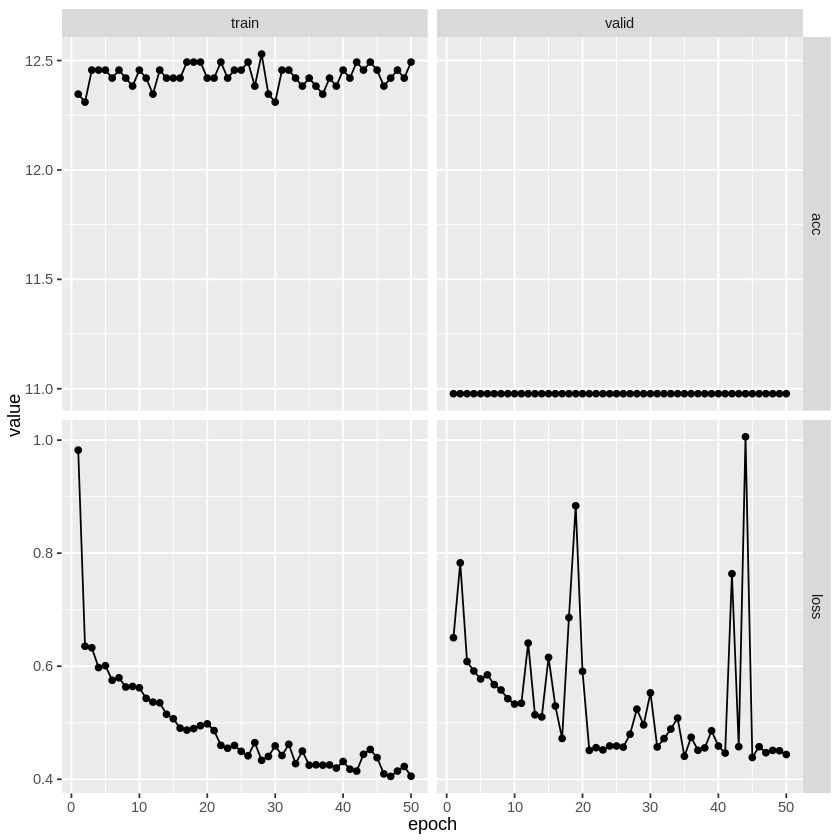

In [11]:
plot(fit_nn)

In [12]:
nn_test <- predict(
    fit_nn, 
    model.matrix(y ~ . - 1, data = df_test)
)
# nn_test
nn_preds <- ifelse(nn_test > 0.5, 1, 0)

table(nn_preds, df_test$y)
mean(nn_preds == df_test$y)

        
nn_preds  0  1
       0 98 21
       1 15 43

[1] 0.7966102

In [13]:
table(glm_preds, df_test$y)
mean(glm_preds == df_test$y)

         
glm_preds   0   1
        0 100  23
        1  13  41

[1] 0.7966102

<br><br><br><br>

---

### DataLoaders

* Dataloaders are a key component in the machine learning pipeline.

* They handle loading and preprocessing data in a way that is efficient for training and evaluating models.

* Dataloaders make it easy to work with large datasets by loading the data in smaller chunks (called **batches**) and applying transformations _on-the-fly_.


##### Why use Dataloaders?

> * **Efficient memory management:** loading data in smaller chunks reduces memory usage.
>
> * **Parallelism:**  supports asynchronous data loading for faster processing.
>
> * **Preprocessing:**  apply data transformations on-the-fly during training and evaluation.
>
> * **Flexibility:**  easily switch between different datasets or preprocessing steps.
>
> * **Standardization:**  consistent data format across various machine learning projects.
>

In [203]:
# ?dataloader

In [204]:
transform <- function(x) x %>% 
    torch_tensor() %>% 
    torch_flatten() %>% 
    torch_div(255)

In [205]:
dir <- "./mnist"

train_ds <- mnist_dataset(
  dir,
  download = TRUE,
  transform = transform
)

test_ds <- mnist_dataset(
  dir,
  download = TRUE,
  train = FALSE,
  transform = transform
)

In [206]:
typeof(train_ds)
length(train_ds)
train_ds$data[42000, ,]

[1] "environment"

[1] 60000

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,42,218,134,186,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,27,221,253,252,221,16,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,16,190,253,252,252,108,0,0,0
0,0,0,0,0,0,0,0,1,109,⋯,0,0,0,109,252,236,62,0,0,0
0,0,0,0,0,0,0,0,125,252,⋯,0,0,0,109,252,215,42,0,0,0
0,0,0,0,0,0,0,0,62,189,⋯,0,0,21,212,252,241,221,0,0,0


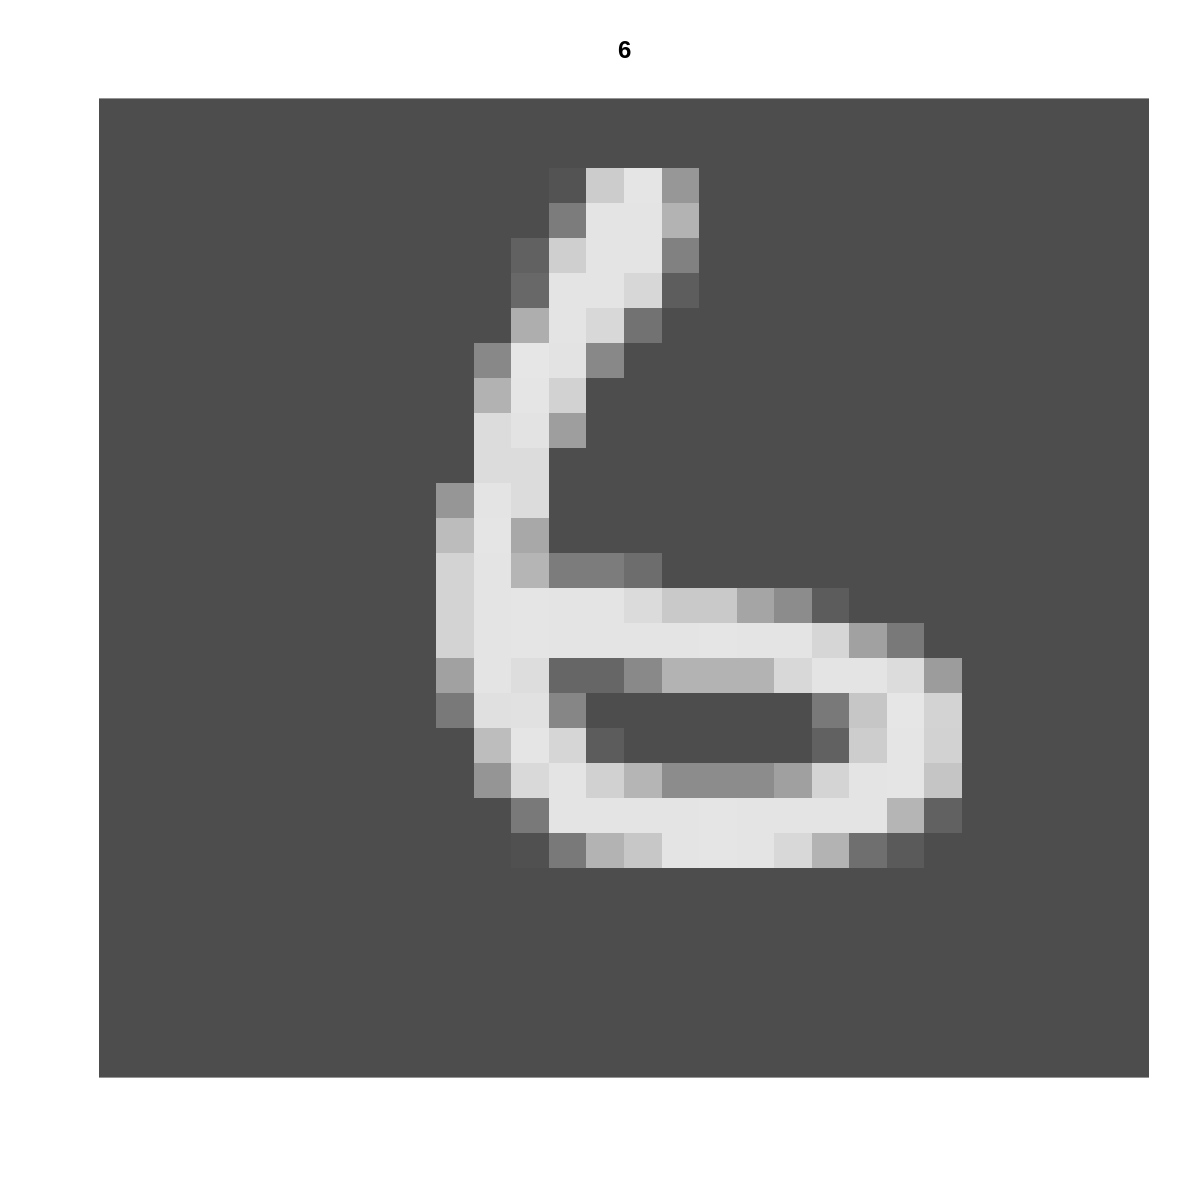

In [207]:
options(repr.plot.width=10, repr.plot.height=10)

i <- sample(1:length(train_ds), 1)
x <- train_ds$data[i, ,] %>% t

image(x[1:28, 28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000), main = train_ds$targets[i]-1 )

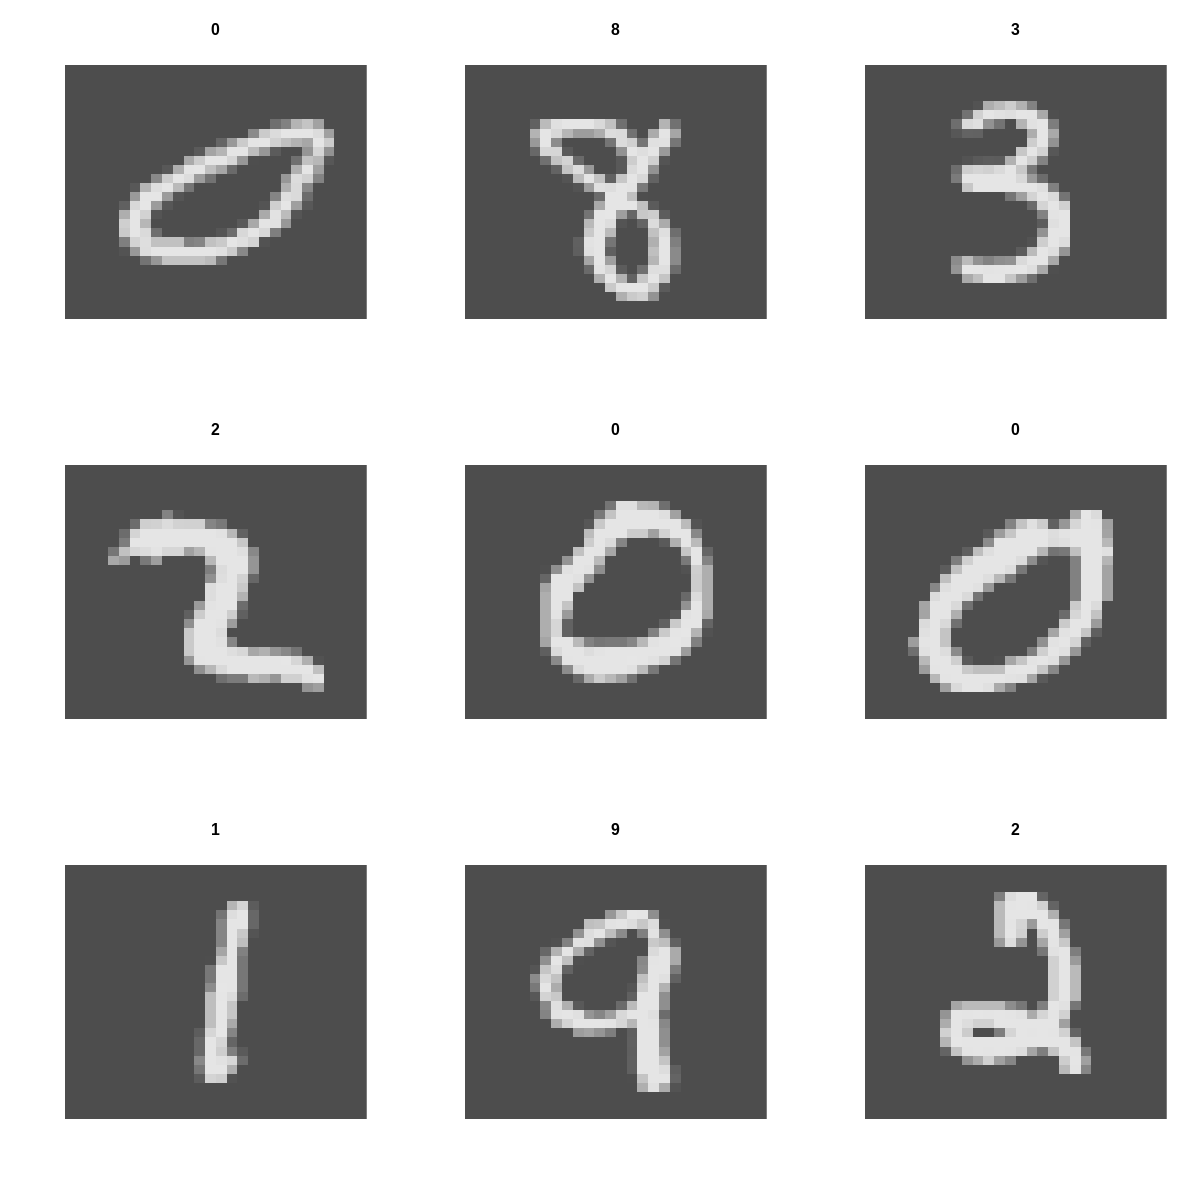

In [208]:
options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow=c(3,3))

for(iter in 1:9){
    i <- sample(1:length(train_ds), 1)
    x <- train_ds$data[i, ,] %>% t
    image(x[1:28, 28:1], useRaster = TRUE, axes = FALSE, col = gray.colors(1000), main = train_ds$targets[i]-1)
}

<br><br><br><br>
<br><br><br><br>


---

# Image Classification

In [193]:
train_dl <- dataloader(train_ds, batch_size = 2000, shuffle = TRUE)
test_dl <- dataloader(test_ds, batch_size = 2000)

In [195]:
NNet_10 <- nn_module(
  initialize = function(p, q1, q2, q3, o) {
    self$hidden1 <- nn_linear(p, q1)
    self$hidden2 <- nn_linear(q1, q2)
    self$hidden3 <- nn_linear(q2, q3)
    self$OUTPUT <- nn_linear(q3, o)
    self$activation <- nn_relu()
  },
  forward = function(x) {
    x %>%
      self$hidden1() %>%
      self$activation() %>%
      self$hidden2() %>%
      self$activation() %>%
      self$hidden3() %>%
      self$activation() %>%
      self$OUTPUT()
  }
)

In [196]:
fit_nn <- NNet_10 %>%
    #
    # Setup the model
    #
    setup(
        loss = nn_cross_entropy_loss(),
        optimizer = optim_adam,
        metrics = list(
            luz_metric_accuracy()
        )
    ) %>%
    #
    # Set the hyperparameters
    #
    set_hparams(p=28*28, q1=256, q2=128, q3=64, o=10) %>% 
    #
    # Fit the model
    #
    fit(
        #
        # Training Data
        #
        epochs = 10,
        data = train_dl,
        # valid_data = test_dl,
        verbose=TRUE
    )

Epoch 1/10
Train metrics: Loss: 1.4951 - Acc: 0.5863
Epoch 2/10
Train metrics: Loss: 0.4406 - Acc: 0.8731
Epoch 3/10
Train metrics: Loss: 0.3131 - Acc: 0.9107
Epoch 4/10
Train metrics: Loss: 0.2596 - Acc: 0.9264
Epoch 5/10
Train metrics: Loss: 0.224 - Acc: 0.9369
Epoch 6/10
Train metrics: Loss: 0.1935 - Acc: 0.9455
Epoch 7/10
Train metrics: Loss: 0.1685 - Acc: 0.9519
Epoch 8/10
Train metrics: Loss: 0.1529 - Acc: 0.956
Epoch 9/10
Train metrics: Loss: 0.1374 - Acc: 0.9604
Epoch 10/10
Train metrics: Loss: 0.1228 - Acc: 0.9646


In [236]:
NN10_preds <- fit_nn %>% 
  predict(test_ds) %>% 
  torch_argmax(dim = 2) %>%
  as_array()

In [239]:
NN10_preds <- NN10_preds -1 

In [240]:
table(
    NN10_preds %>% as.factor(),
    (test_ds$targets-1) %>% as.factor()
)

   
       0    1    2    3    4    5    6    7    8    9
  0  963    0    5    0    1    2    7    0    4    5
  1    0 1118    2    0    0    1    3   13    2    6
  2    1    3  994    8    5    0    2   12    3    1
  3    1    2    9  963    1    5    0    4   15   11
  4    0    0    1    1  943    1    7    1    5   17
  5    6    1    1   18    0  864    9    1   14    5
  6    5    5    5    0    6    7  926    0    9    1
  7    2    2    6    8    2    1    0  983    8    4
  8    1    4    7   11    3    5    4    2  910    5
  9    1    0    2    1   21    6    0   12    4  954

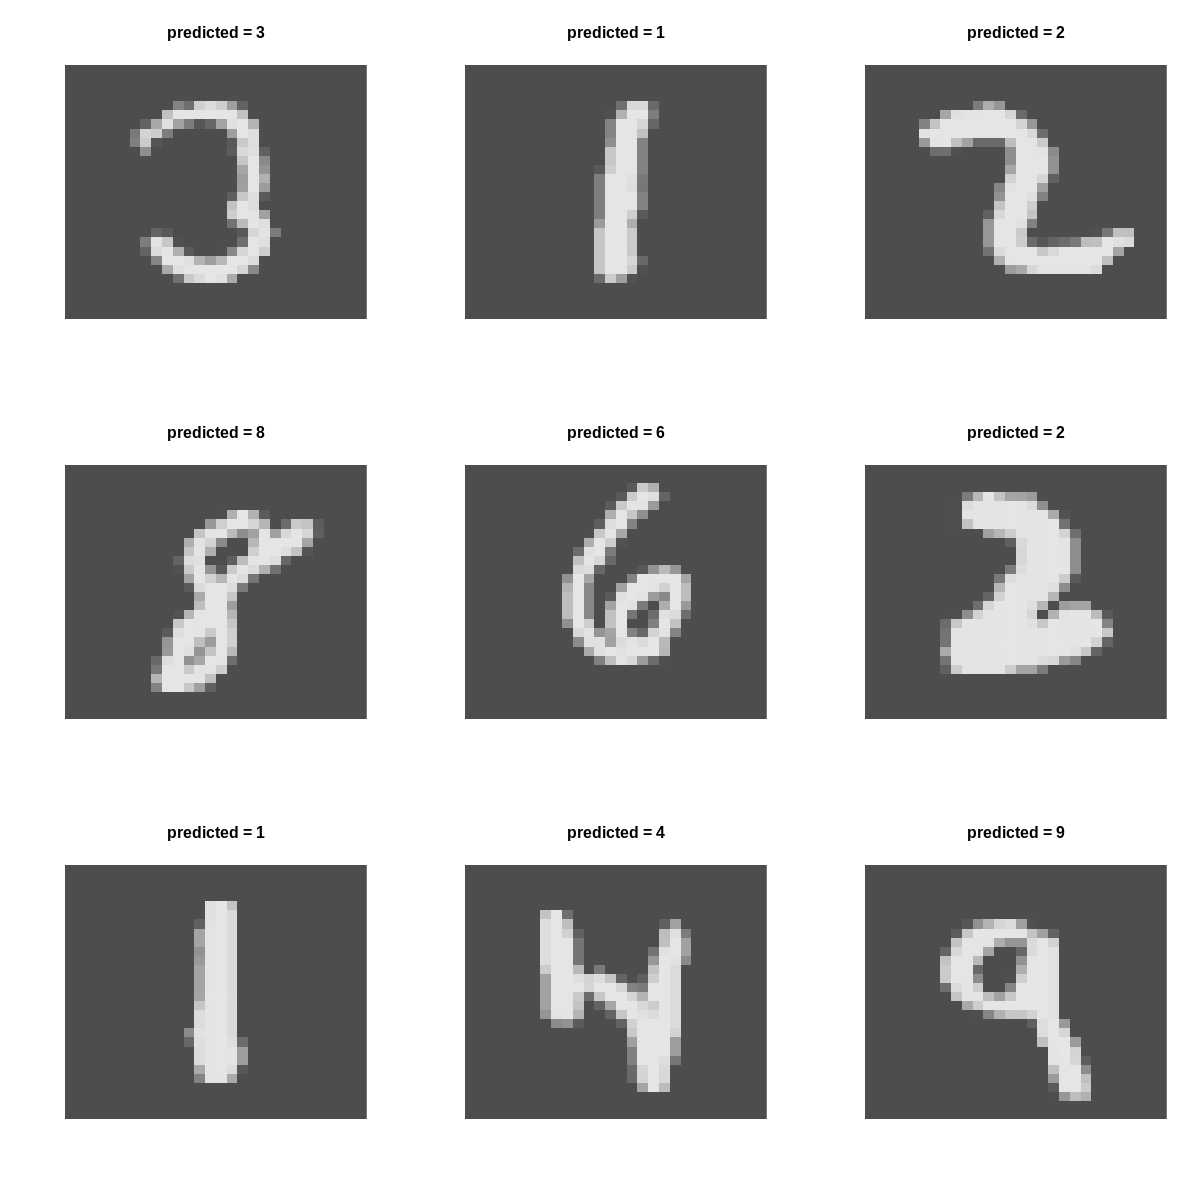

In [242]:
options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow=c(3,3))

for(iter in 1:9){
    i <- sample(1:length(test_ds), 1)
    x <- test_ds$data[i, ,] %>% t
    image(x[1:28, 28:1], useRaster = TRUE, axes = FALSE, col = gray.colors(1000), main = paste("predicted =", NN10_preds[i]))
}

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

---

# Thu, Apr 13


## Supervised learning

For a majority of this course we have focused on **supervised learning** where we have access to **labelled data** i.e., we are given access to the _covariates and the responses_

<br><br><br>

$$
\begin{aligned}
\text{observation}\ 1: &\quad (X_{1, 1}, X_{2, 1}, \dots X_{p, 1}, y_1)\\
\text{observation}\ 2: &\quad (X_{1, 2}, X_{2, 2}, \dots X_{p, 2}, y_2)\\
\vdots\quad & \quad\quad\quad\vdots\\ 
\text{observation}\ n: &\quad (X_{1, n}, X_{2, n}, \dots X_{p, n}, y_n)
\end{aligned}
$$

<br><br><br>

Our **goal** has been to:

* Predict $y$ using $X_1, X_2, \dots X_p$
* Understand how each $X_i$ influences the response $y$

## Unsupervised learning

In unsupervised learning we **DON'T** have access to the labelled data, i.e., we are only given:

<br><br><br>

$$
\begin{aligned}
\text{observation}\ 1: &\quad (X_{1, 1}, X_{2, 1}, \dots X_{p, 1})\\
\text{observation}\ 2: &\quad (X_{1, 2}, X_{2, 2}, \dots X_{p, 2})\\
\vdots\quad & \quad\quad\quad\vdots\\ 
\text{observation}\ n: &\quad (X_{1, n}, X_{2, n}, \dots X_{p, n})
\end{aligned}
$$

<br><br><br>

Our **goal** here is:
* To understand the relationship between $X_1, X_2, \dots X_p$
    > * **dimension reduction**: 
    > 
    > Can we discover subgroups of variables $X_1, X_2, \dots X_p$ which behave similarly?
    
    > * **clustering**:
    >
    > Can we discover subgroups of observations $1, 2, \dots n$ which are similar?
    
<br><br><br>

#### Why unsupervised learning?

It is always easier to obtain unlabeled data as oppposed to labeled data (which require someone or something to actually assign the proper responses $y_1, y_2, \dots y_n$)

In statistics and data science, there are a multitude of different methods which have been proposed to tackle each of the two problems. They include:

* **Dimension reduction**:
    * Principal component analysis
    * Uniform Manifold Approximation (UMAP)
    * t-Stochastic Neighbor embedding (t-SNE)
    * ...
    
* **Clustering**:
    * k-means clustering
    * Hierarchical clustering
    * Topological clustering
    * Laplacian eigenmaps
    * ...
    
This is one of the most exciting parts of data-science

---


## Principal Component Analysis (PCA)

Given variables $(X_1, X_2, \dots X_p)$, PCA produces a low-dimensional representation of the dataset, i.e., 

<br><br>

$$
\begin{aligned}
\text{observation}\ 1: &\quad (X_{1, 1}, X_{2, 1}, \dots X_{p, 1}) \longrightarrow (Z_{1, 1}, Z_{2, 1})\\
\text{observation}\ 2: &\quad (X_{1, 2}, X_{2, 2}, \dots X_{p, 2}) \longrightarrow (Z_{1, 2}, Z_{2, 2})\\
\vdots\quad & \quad\quad\quad\vdots\\ 
\text{observation}\ n: &\quad (X_{1, n}, X_{2, n}, \dots X_{p, n}) \longrightarrow (Z_{1, n}, Z_{2, n})
\end{aligned}
$$

<br><br>

It tries to create variables $(Z_1, Z_2, \dots Z_q)$ for $q < p$ such that:

1. $q \ll p$
1. $(Z_1, Z_2, \dots Z_q)$ contains _roughly_ the same information as $(X_1, X_2, \dots X_p)$

#### How does PCA achieve this?


---

<br><br>


##### Step 1:

The **first principal component** $Z_1$ is the _normalized_ linear combination of the features:

<br><br>

$$
Z_1 = v_{11} X_1 + v_{21} X_2 + \dots v_{p1} X_p
$$

<br><br>

such that: 
* $Z_1$ has the largest possible variance
* $\sum_{i=1}^p v^2_{p, i} = 1$

<br><br>


> #### Note:
> $V_1 = (v_{11}, v_{21}, \dots v_{p1})$ are called the **factor loadings**

<br><br>

---

<br><br>


##### Step 2:

The **second principal component** $Z_2$ is the _normalized_ linear combination of the features:

<br><br>

$$
Z_2 = v_{12} X_1 + v_{22} X_2 + \dots v_{p2} X_p
$$

<br><br>

such that: 
* $V_2 \perp V_1$
* $Z_2$ has the largest possible variance
* $\sum_{i=1}^p v^2_{p, 2} = 1$

<br><br>

---

$\vdots\\\vdots$

---

##### Step q:

The **$q$th principal component** $Z_q$ is the _normalized_ linear combination of the features:

<br><br>

$$
Z_2 = v_{12} X_1 + v_{22} X_2 + \dots v_{p2} X_p
$$

<br><br>

such that: 
* $Z_q$ has the largest possible variance
* $V_q \perp \text{span}(V_1, V_2, \dots, V_{q-1})$
* $\sum_{i=1}^p v^2_{p, 2} = 1$

<br><br>



<br><br>

## Example in `R`

In R, we can use the built-in function prcomp() to perform PCA.

In [100]:
data <- tibble(
  x1 = rnorm(100, mean = 0, sd = 1),
  x2 = x1 + rnorm(100, mean = 0, sd = 0.1)
)

In [106]:
pca <- princomp(data, cor = TRUE)
summary(pca)

Importance of components:
                          Comp.1      Comp.2
Standard deviation     1.4117122 0.084075612
Proportion of Variance 0.9964656 0.003534354
Cumulative Proportion  0.9964656 1.000000000

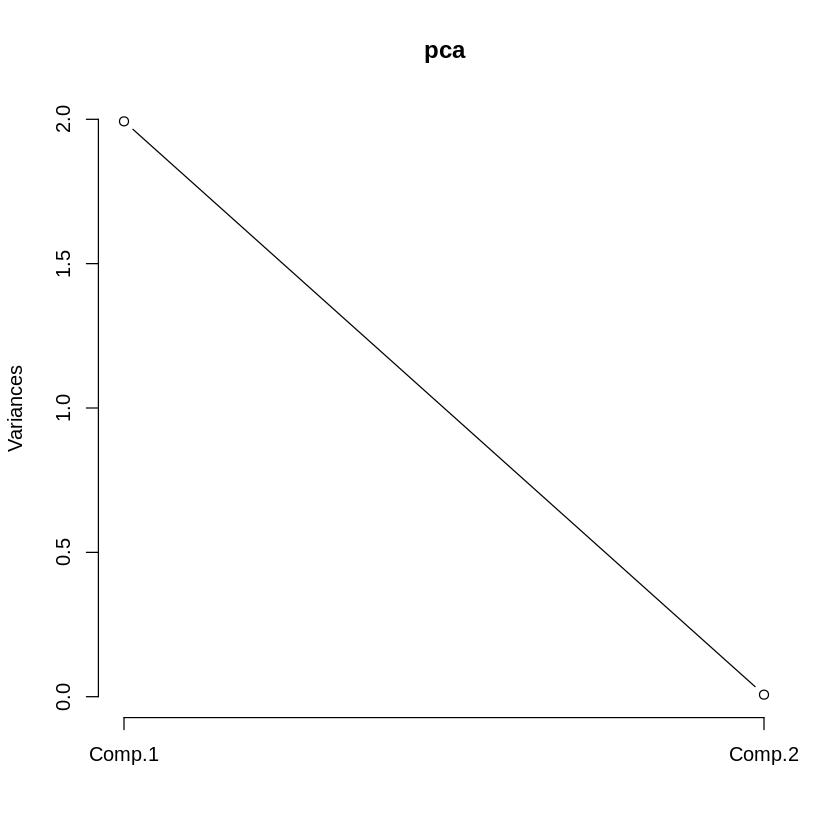

In [107]:
screeplot(pca, type="l")

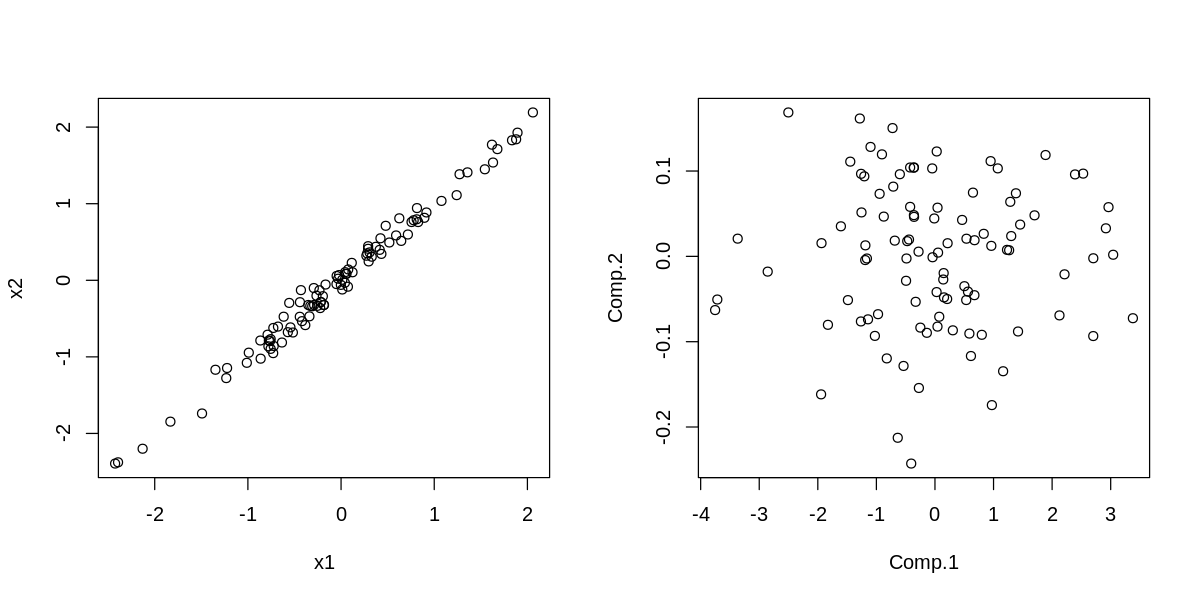

In [108]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1, 2))

Z_pca <- predict(pca, data[, 1:2])
plot(data)
plot(Z_pca)

---



### Interpretation of principal components



In [109]:
n <- 500
science <- rnorm(n, mean = 60, sd = 10)
humanities <- rnorm(n, mean = 80, sd=10)

In [121]:
set.seed(42)
df <- tibble(
  math = 0.8 * science + rnorm(n, mean = 0, sd = 7),
  physics = 1.0 * science + rnorm(n, mean = 0, sd = 5),
  chemistry = 1.3 * science + rnorm(n, mean = 0, sd = 3),
  history = 0.8 * humanities + rnorm(n, mean = 0, sd = 5),
  geography = 1.0 * humanities + rnorm(n, mean = 0, sd = 10),
  literature = 1.2 * humanities + rnorm(n, mean = 0, sd = 2)
)

In [127]:
head(df)

math,physics,chemistry,history,geography,literature
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
62.72906,71.56114,93.31525,56.52949,76.92628,90.53928
55.30130,78.64160,97.86042,61.75750,75.26649,93.64579
50.70690,60.19397,81.18033,63.95318,68.86457,103.15180
52.07501,60.23626,78.55400,77.64647,71.79151,111.03019
45.93821,50.28465,67.06324,71.78750,81.78542,114.82201
31.96543,39.89476,51.35854,67.66842,86.11600,98.91538


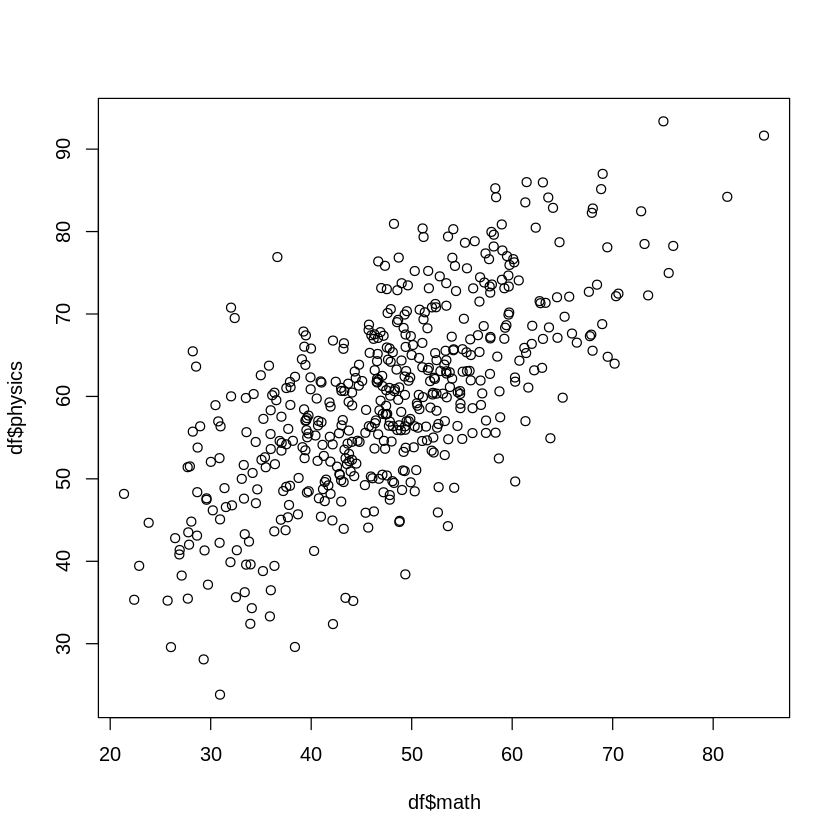

In [128]:
options(repr.plot.width=7, repr.plot.height=7)
plot(df$math, df$physics)

In [129]:
pca <- princomp(df, cor=TRUE)
summary(pca)

Importance of components:
                          Comp.1    Comp.2     Comp.3    Comp.4     Comp.5
Standard deviation     1.5958957 1.5504512 0.66579452 0.5759531 0.39267017
Proportion of Variance 0.4244805 0.4006498 0.07388039 0.0552870 0.02569831
Cumulative Proportion  0.4244805 0.8251303 0.89901070 0.9542977 0.97999601
                           Comp.6
Standard deviation     0.34644470
Proportion of Variance 0.02000399
Cumulative Proportion  1.00000000

In [130]:
pca$loadings


Loadings:
           Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
math        0.551                0.813         0.182
physics     0.581               -0.529         0.612
chemistry   0.598               -0.235        -0.763
history           -0.583  0.526        -0.616       
geography         -0.538 -0.819        -0.187       
literature        -0.608  0.222         0.758       

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.167  0.167  0.167  0.167  0.167  0.167
Cumulative Var  0.167  0.333  0.500  0.667  0.833  1.000

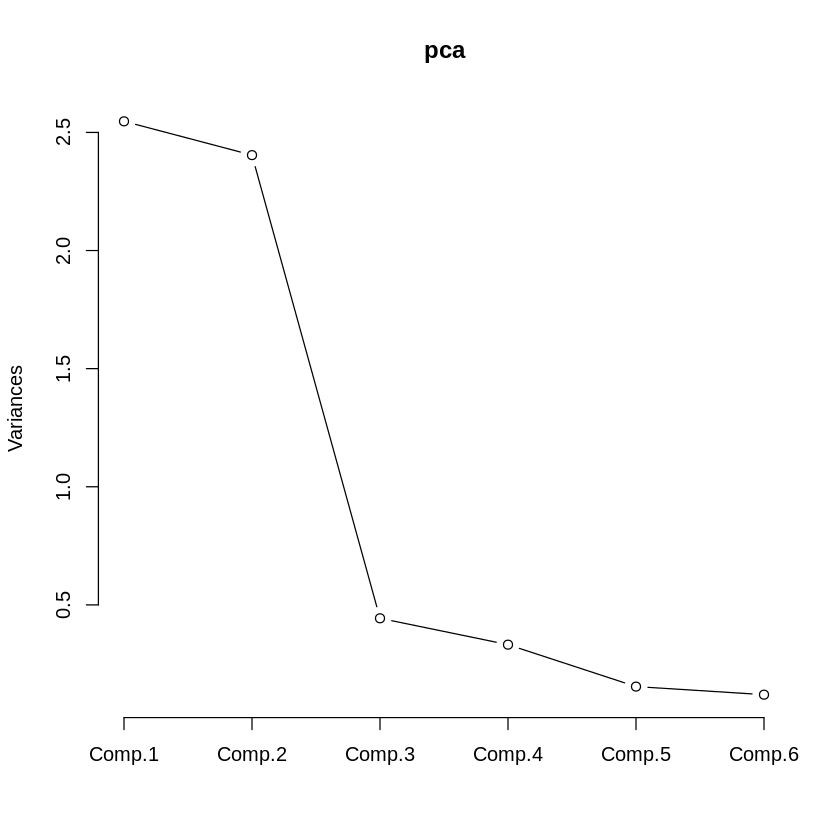

In [131]:
plot(pca, type="l")

---

#### Principal component regression

In [141]:
df$gpa <- (0.9 * science + 0.5 * humanities + rnorm(n, mean=0, sd=10)) * 4 / 100

In [142]:
head(df)

math,physics,chemistry,history,geography,literature,gpa
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
62.72906,71.56114,93.31525,56.52949,76.92628,90.53928,3.822642
55.30130,78.64160,97.86042,61.75750,75.26649,93.64579,3.901794
50.70690,60.19397,81.18033,63.95318,68.86457,103.15180,3.759447
52.07501,60.23626,78.55400,77.64647,71.79151,111.03019,4.132458
45.93821,50.28465,67.06324,71.78750,81.78542,114.82201,3.036151
31.96543,39.89476,51.35854,67.66842,86.11600,98.91538,2.721283


In [143]:
lm_fit <- lm(gpa ~ ., df)
summary(lm_fit)


Call:
lm(formula = gpa ~ ., data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.25743 -0.30757  0.01623  0.28850  1.23963 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.071525   0.189667   0.377 0.706256    
math        -0.002119   0.002762  -0.767 0.443362    
physics      0.010703   0.003422   3.128 0.001863 ** 
chemistry    0.020515   0.003272   6.271 7.86e-10 ***
history      0.004258   0.003716   1.146 0.252430    
geography    0.002150   0.001903   1.130 0.259018    
literature   0.011402   0.003227   3.533 0.000449 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4276 on 493 degrees of freedom
Multiple R-squared:  0.4915,	Adjusted R-squared:  0.4853 
F-statistic: 79.41 on 6 and 493 DF,  p-value: < 2.2e-16


In [153]:
vif(lm_fit) %>% t

math,physics,chemistry,history,geography,literature
2.391157,4.138398,5.190626,3.252924,1.879114,4.044063


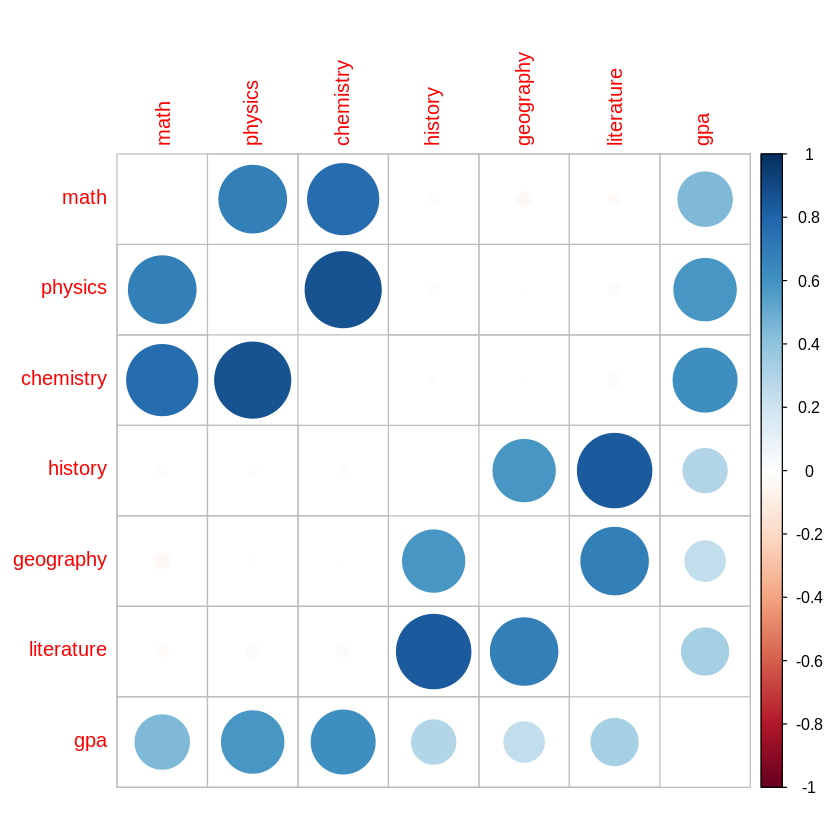

In [158]:
df %>% 
    # select(-gpa) %>% 
    cor() %>% 
    corrplot(diag=F)

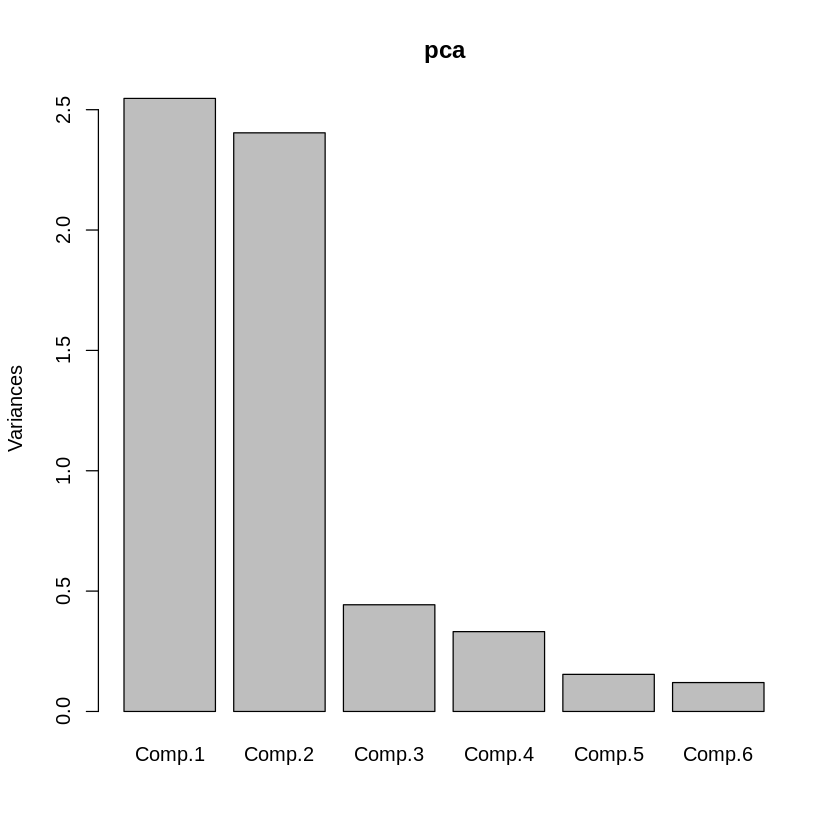

In [166]:
pca <- princomp(df %>% select(-gpa), cor=TRUE)
screeplot(pca)

In [186]:
Z <- predict(pca, df)

df_pca <- Z %>% 
    as_tibble %>% 
    select(Comp.1, Comp.2) %>% 
    mutate(gpa = df$gpa)

head(df_pca)

Comp.1,Comp.2,gpa
<dbl>,<dbl>,<dbl>
2.0631176,0.90588241,3.822642
2.2598119,0.46384319,3.901794
0.3485496,0.07000813,3.759447
0.3377516,-1.30354715,4.132458
-1.0051541,-1.54222665,3.036151
-2.9919454,-0.68932090,2.721283


In [188]:
lm_pca <- lm(gpa ~ ., df_pca)
summary(lm_pca)


Call:
lm(formula = gpa ~ ., data = df_pca)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.35146 -0.30232  0.03189  0.28849  1.24049 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.73933    0.01959 190.892   <2e-16 ***
Comp.1       0.22479    0.01227  18.314   <2e-16 ***
Comp.2      -0.12081    0.01263  -9.562   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.438 on 497 degrees of freedom
Multiple R-squared:  0.462,	Adjusted R-squared:  0.4599 
F-statistic: 213.4 on 2 and 497 DF,  p-value: < 2.2e-16


In [190]:
vif(lm_pca) %>% t

Comp.1,Comp.2
1,1
